## Pulser assignement ##

In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipBackend
from pulser.devices import MockDevice
from pulser.waveforms import RampWaveform, ConstantWaveform


import matplotlib.pyplot as plt
import networkx as nx

Creates a layout that matches the problem

In [2]:
def graph_layout(pos, blockade_radius):
    """Creates the graph layout for the given positions and blockade radius.

    Args:
        pos (list): list of the position (x, y) of each atom
        blockade_radius (float): the value of the blockade radius

    Returns:
        Register, int: the register and the maximum Rabi frequency
    """
    reg = Register.from_coordinates(pos)
    Omega_max = MockDevice.rabi_from_blockade(blockade_radius)
    return reg, Omega_max
    

In [3]:
# Define the maximum Rabi frequency by imposing a blockade radius
# (units are um for the blockade radius and rad/us for the rabi frequency)

final_colors = [-1] * 8

blockade_radius = 8.7
initial_pos = [(0, 0), (3, 5.2), (6, 0), (9, -5.2), (9, 0), (9, 5.2), (9, 10.4), (12, 0)]
reg, Omega_max = graph_layout([(0, 0), (3, 5.2), (6, 0), (9, -5.2), (9, 0), (9, 5.2), (9, 10.4), (12, 0)], blockade_radius)

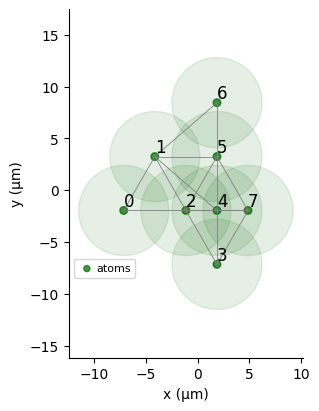

In [4]:
# Visualize the edges induced by the chosen blockade radius
reg.draw(blockade_radius=blockade_radius,  draw_half_radius=True)

Functions for creating a graph using a list of positions

In [5]:
def compute_distance(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)


def create_edges_from_position_and_distance(pos, blockade_radius):
    edges = []
    for i in range(len(pos)):
        for j in range(i+1, len(pos)):
            if compute_distance(pos[i], pos[j]) < blockade_radius:
                edges.append((i,j))
    return edges

The cells below create a custom graph that will be used to identify the group of each node later

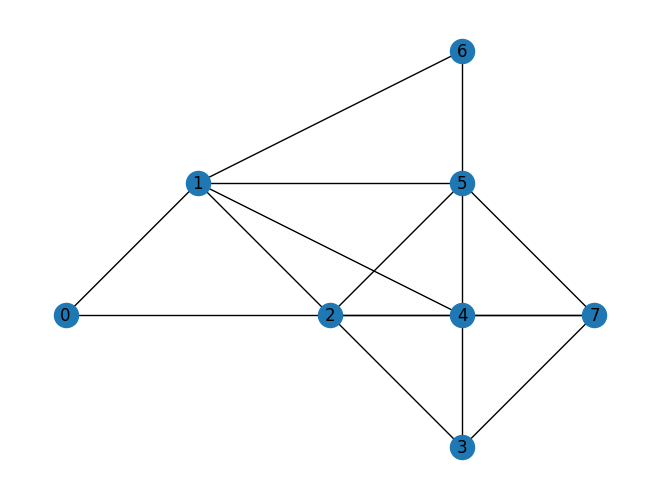

In [6]:
vertices = [0,1,2,3,4,5,6,7]
edges = create_edges_from_position_and_distance(initial_pos, blockade_radius)
pos = {}
for i in range(len(initial_pos)):
    pos[i] = initial_pos[i]

#visual graph creation
G = nx.Graph()
G.add_nodes_from(vertices)
G.add_edges_from(edges)
nx.draw(G, pos, with_labels=True)

Solving the problem with Pulser

In [7]:
def get_pulse(seq):
    """Add the predefined pulses to the sequence.

    Args:
        seq (Sequence): The sequence to which the pulses are added
    """
    # And now we can create the pulse and add it to the channel
 
    #First ramp
    omega_wf_1 = RampWaveform(300, 0, Omega_max) #arguments are duration (ns), initial Omega (rad/us), final Omega (rad/us)
    delta_wf_1 = ConstantWaveform(300, -40) #arguments are duration (ns), detuning (rad/us)
    first_pulse = Pulse(omega_wf_1, delta_wf_1, 0)
    seq.add(first_pulse, 'ch')

    # Do the same for the other two pulses

    # Middle part
    omega_wf_2 = ConstantWaveform(1000, Omega_max)
    delta_wf_2 = RampWaveform(1000, -40, 20)
    middle_pulse = Pulse(omega_wf_2, delta_wf_2, 0)
    seq.add(middle_pulse, 'ch')

    # Final ramp
    omega_wf_3 = RampWaveform(300, Omega_max, 0)
    delta_wf_3 = ConstantWaveform(300, 20)
    final_pulse = Pulse(omega_wf_3, delta_wf_3, 0)
    seq.add(final_pulse, 'ch')

In [8]:
# A Sequence is the object that contains all the info about the quantum evolution
seq = Sequence(reg, MockDevice)

#Channel declaration
seq.declare_channel('ch', 'rydberg_global')

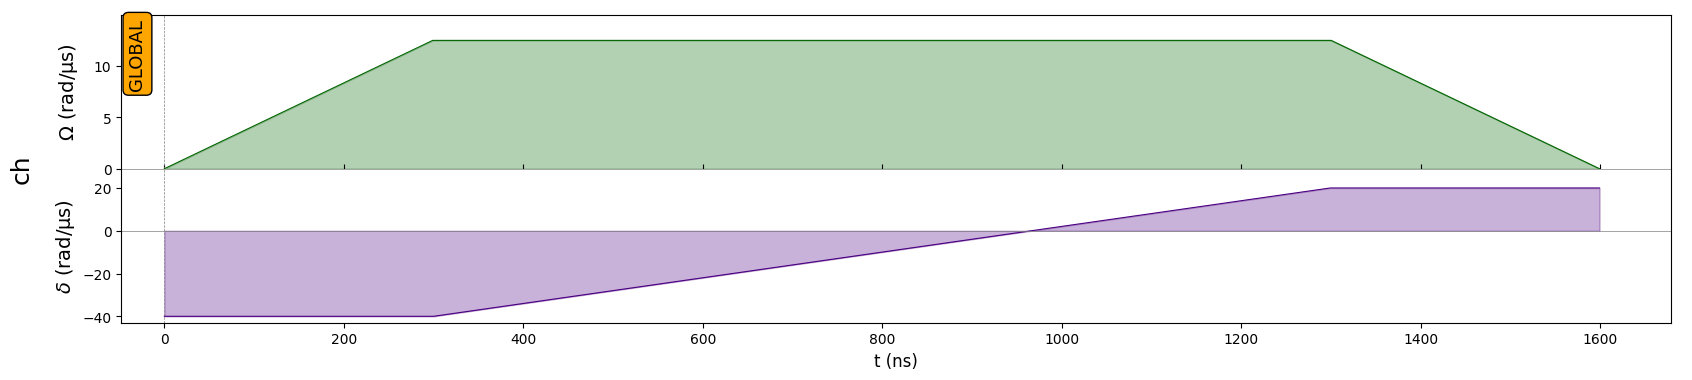

In [9]:
get_pulse(seq)
seq.draw()

Applying the pulses to solve our MIS problem

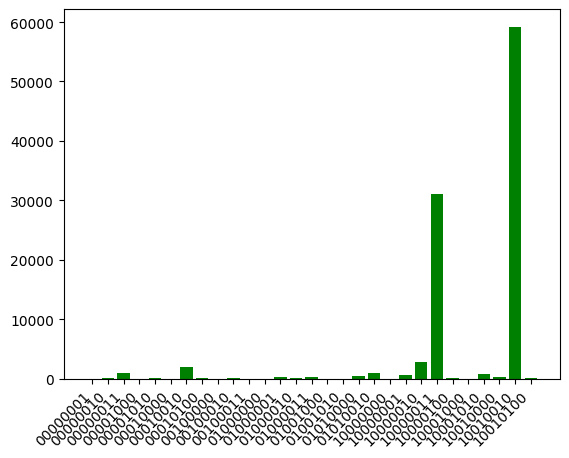

3448.2758620689656

In [10]:
sim = QutipBackend(seq)
res = sim.run()
shots = 100000
sampl = res.sample_final_state(shots)

plt.bar(sampl.keys(), sampl.values(),color='g')
plt.xticks(rotation=45, ha="right")
plt.show()

# Set a threshold to filter out noisy MIS, only leaving the potentially relevant ones 
threshold = shots/len(sampl)
threshold

In [11]:
# Get the MIS that meet the threshold
best_mis = [key for (key, val) in filter(lambda kv: kv[1] > threshold, sampl.most_common())]
print("The MIS that are above the threshold are", best_mis)

# For now we will only use the MIS with highest probability
colors = sampl.most_common()[0][0]
print("The MIS that we keep for this example is", colors)

The MIS that are above the threshold are ['10010010', '10000011']
The MIS that we keep for this example is 10010010


Let's check the colored graph

In [12]:
def from_grp_to_colors(group):
    """Change the numbers to colors name.

    Args:
        group (list): list of numbers corresponding to antenna groups

    Returns:
        list: list of color strings corresponding antenna groups
    """
    possible_colors = ['red','blue','green','purple','yellow', 'white', 'black']
    color_index = 0
    grp_colors = ['black'] * len(group)
    grp_checked = []
    for i in range(len(group)):
        ele = group[i]
        if ele not in grp_checked:
            grp_checked.append(ele)
            color = possible_colors[color_index]
            for y in range(i, len(group)):
                if group[i] == group[y]:
                    grp_colors[y] = color
            color_index += 1
    return grp_colors

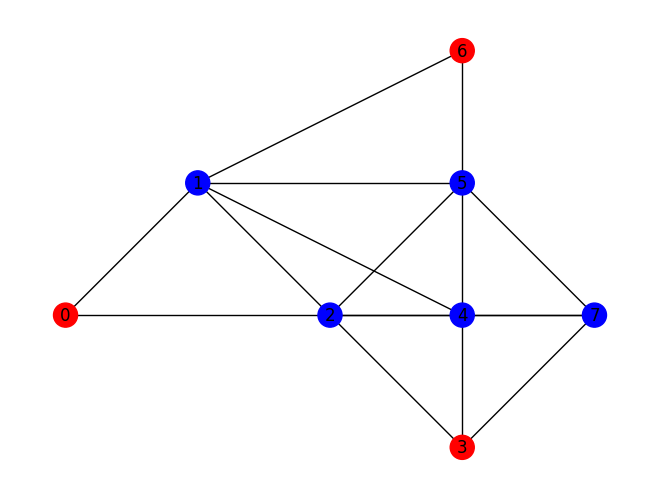

In [13]:
naive_first_separation = []
for ele in colors:
    naive_first_separation.append(int(ele))

naive_colors = from_grp_to_colors(naive_first_separation)
nx.draw(G, pos, node_color=naive_colors, with_labels=True)

Many close antennas are still in the same frequencies.

Let's reapply our algorithm on the blue group to separate the close nodes.
There is no need to apply the algorithm on the red group as it is already an MIS.

In [14]:
# Creates the list used to differentiate the two groups
#The Nodes positions
zeros = []
#The index matching the position in the original array of positions
zeros_index = []
ones = []
ones_index = []
for i in range(len(colors)):
    grp = colors[i]
    if grp == '0':
        zeros.append(initial_pos[i])
        zeros_index.append(i)
    else:
        ones.append(initial_pos[i])
        ones_index.append(i)



## Second MIS ##
Let's apply MIS algorithm to the sub graph where 0 was measured (blue group)

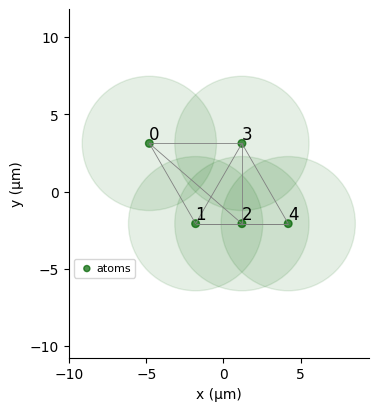

In [15]:
reg_zeros, Omega_max = graph_layout(zeros, blockade_radius)
reg_zeros.draw(blockade_radius=blockade_radius,  draw_half_radius=True)

In [16]:
# A Sequence is the object that contains all the info about the quantum evolution
seq_zeros = Sequence(reg_zeros, MockDevice)

#Channel declaration
seq_zeros.declare_channel('ch', 'rydberg_global')
get_pulse(seq_zeros)


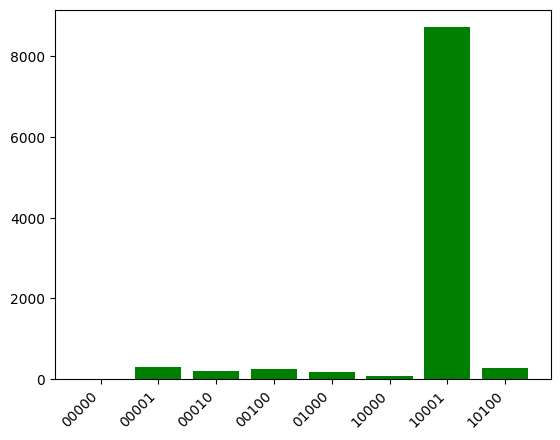

In [17]:
sim = QutipBackend(seq_zeros)
res = sim.run()
shots = 10000
sampl = res.sample_final_state(shots)

plt.bar(sampl.keys(), sampl.values(),color='g')
plt.xticks(rotation=45, ha="right")
plt.show()


In [18]:
color_index = 0
colors_zeros  = sampl.most_common()[0][0]
for i in range(len(colors_zeros)):
    grp = colors_zeros[i]
    if grp == '0':
        final_colors[zeros_index[i]] = color_index
    else:
        final_colors[zeros_index[i]] = color_index + 1

print(final_colors)
color_index += 2

[-1, 1, 0, -1, 0, 0, -1, 1]


Here is the graph after applying the algorithm, a new group has appeared (green)

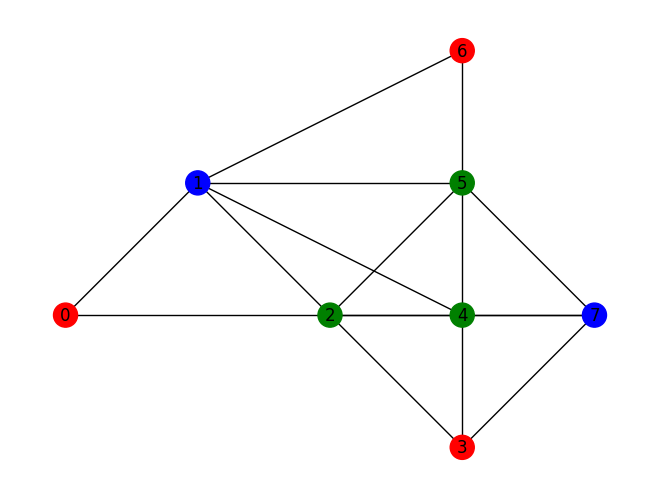

In [19]:
better_colors = from_grp_to_colors(final_colors)
nx.draw(G, pos, node_color=better_colors, with_labels=True)

Better results but still not perfect.

We need to continue applying the algorithm as long as one group still has at least two antennas close 

## AUTO ##

Here is the automatic version that continues to run on the sub-groups until no groups has any close antenna or until the algorithm doesn't find any new separation 

In [20]:
def check_element_proximity_in_list(arr, blockade_radius):
    """Checks if there are positions in the list that are close enough to be connected
    Args:
        arr (array): list of positions
        blockade_radius (float): minimum distance between connected positions

    Returns:
        boolean: True if two positions are connected in the list
    """
    for i in range(len(arr)):
        for j in range(i+1, len(arr)):
            if compute_distance(arr[i], arr[j]) < blockade_radius:
                return True
    return False

In [21]:

def get_the_groups(arr, blockade_radius, final_colors, index_list, color_grp=0, only_max=True):
    """The function that recursively call the MIS algorithm on the groups to find the best groups of atoms.

    Args:
        arr (list): list of the position of the atoms/antennas to separate  
        blockade_radius (float): the minimum distance allowed between antennas
        final_colors (list): The array describing the group of each antenna
        index_list (list): a list of index used to fill final colors at the right position
        color_grp (int, optional): the current index of the colors. Defaults to 0.
        only_max (bool, optional): set to false to try multiple MIS instead of the most measured one

    Returns:
        list, int: The upadated group list and the current index of the colors
    """

    # Model our antennas as Rydberg atoms
    reg, _ = graph_layout(arr, blockade_radius)
    # A Sequence is the object that contains all the info about the quantum evolution
    seq = Sequence(reg, MockDevice)

    #Channel declaration
    seq.declare_channel('ch', 'rydberg_global')
    get_pulse(seq)

    sim = QutipBackend(seq)
    res = sim.run()
    shots = 10000
    sampl = res.sample_final_state(shots)

    threshold = shots/len(sampl)

    #Get MIS with the highest probabilities
    best_mis = [key for (key, val) in filter(lambda kv: kv[1] > threshold, sampl.most_common())]
    if only_max:
        best_mis = [best_mis[0]]

    #Variables used to determine the best colors combination between iterations
    (best_colors, color_index) = ([], 0)
    least_colors = shots

    for colors in best_mis:
        # Use the result from the MIS to add the nodes in the groups 
        for i in range(len(colors)):
            grp = colors[i]
            if grp == '0':
                final_colors[index_list[i]] = color_grp
            else:
                final_colors[index_list[i]] = color_grp + 1

        # If the MIS did not find any separation
        if colors == '0' * len(colors) or colors == '1' * len(colors):
            return final_colors, color_grp
        
        # Get the group that needs MISing
        need_mis_pos = []
        need_mis_index = []
        for i in range(len(colors)):
            grp = colors[i]
            if grp == '0':
                need_mis_pos.append(arr[i])
                need_mis_index.append(index_list[i])

        color_grp += 2

        # IF one group has two close element then recursively call the function
        if check_element_proximity_in_list(need_mis_pos, blockade_radius):
            final_colors, color_grp = get_the_groups(need_mis_pos, blockade_radius, final_colors, need_mis_index, color_grp, only_max)

        color_grp += 2

        nb_colors = len(np.unique(need_mis_index))
        if nb_colors < least_colors:
            least_colors = nb_colors
            best_colors = final_colors
            color_index = color_grp
        else:
            final_colors = best_colors
            color_index = color_grp
        
    return best_colors, color_index

In [22]:
#print(final_colors.copy())
#do_shit(zeros, blockade_radius, final_colors.copy(), zeros_index, 0)
initial_index = [i for i in range(len(initial_pos))]
grp_automatize , _ = get_the_groups(initial_pos, blockade_radius, final_colors.copy(), initial_index, 0, True)
print("Group separation found: ", grp_automatize)

Group separation found:  [1, 3, 7, 1, 6, 5, 1, 3]


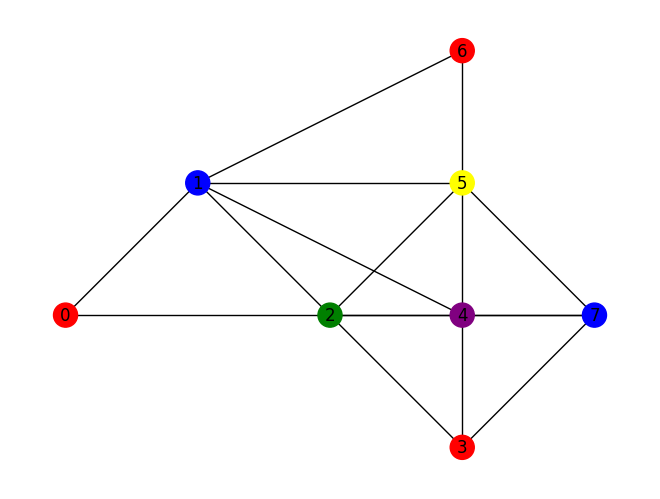

In [23]:
auto_colors = from_grp_to_colors(grp_automatize)
nx.draw(G, pos, node_color=auto_colors, with_labels=True)

This is a decent result but it could be better, as shown in the following graph which has only 4 groups:

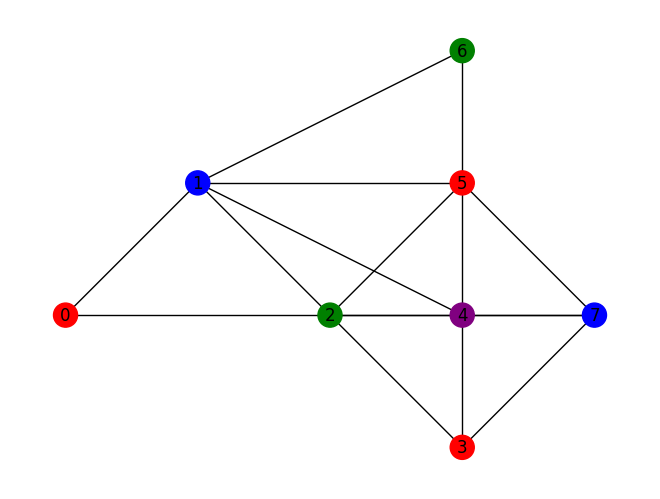

In [24]:
manual_colors = ['red','blue','green','red','purple', 'red', 'green', 'blue']
nx.draw(G, pos, node_color=manual_colors, with_labels=True)